# Agent-based model

This is a model of embryonic neocortex population, using an agent-based framework.
This means that we create cells, on we sample a Tc from the age-related distribution.
At the end of cell cycle, the fate decision for the daughters are.

The model starts at E48, where we have the first data.

Data will be of different types :

Tc:
- Population level estimation
- Cell level estimation

Differentiation:
- Cell level estimation

Number of progenitors:
- Ki67 ratio in GZ
- Ratio of Tbr2+ and Sox2+

Number of cells:
- Relative volume from Histo + MRI
- Density of cells

We will have to discuss quality of the data

In [1]:
# imports
import numpy as np
import seaborn as sns
import tqdm
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
from numpy.random import choice
from scipy.interpolate import splev, splrep, interp1d
from scipy import stats
from gpn2 import GrowingPlanarNetwork
from collections import Counter
from model import AbstractCell, Action, Brain, Submodels
from experiment import Experiment
from utils import nop, highest_lower, Profiler, plot_function
from submodels.cellbasic1 import CellBasic
from submodels.bistate1 import BiStateModelFactory
from submodels.tristate1 import TriStateModelFactory
from submodels import factories
from tree import tree_from_cell, progeny_along_time, plot_progeny

## Loading data

In [2]:
# Volume MRI + Histo
volumes = pd.read_csv('data/VolumeArea17.csv')

## Preprocessing data

In [3]:
# from PolynomRegression
Tc_ = lambda time: 277.36424309532794 - 0.023973977538587 * time - 0.761568634472077 * time**2 + \
    0.025594287611410 * time**3 - 0.000307496975562 * time**4 + 0.000001264230759 * time**5
print("Polynom Reg", Tc_(48), Tc_(65), Tc_(78))

Polynom Reg 41.8919627067869 64.8715873071742 55.96794765296363


In [4]:
# what we do is to average some ages
volumes = volumes.append(volumes.loc[volumes.Age.isin([70, 72])].mean(), ignore_index=True)
volumes = volumes.append(volumes.loc[volumes.Age.isin([78, 79])].mean(), ignore_index=True)
volumes = volumes.append(volumes.loc[volumes.Age.isin([84, 86])].mean(), ignore_index=True)
volumes = volumes.loc[~volumes.Age.isin([70, 72, 78, 79, 84, 86])]

In [5]:
col = volumes.loc[:, ["Ratio_Histo_VZ", "Ratio_MRI_VZ"]]
volumes['Ratio_VZ'] = col.mean(axis=1)
col = volumes.loc[:, ["Ratio_Histo_ISVZ", "Ratio_MRI_ISVZ"]]
volumes['Ratio_ISVZ'] = col.mean(axis=1) * volumes.loc[0, "Histo_ISVZ"] / volumes.loc[0, "Histo_VZ"]
col = volumes.loc[:, ["Ratio_Histo_OSVZ", "Ratio_MRI_OSVZ"]]
volumes['Ratio_OSVZ'] = col.mean(axis=1) * volumes.loc[0, "Histo_OSVZ"] / volumes.loc[0, "Histo_VZ"]

In [6]:
volumes.loc[:, ["AverageDensityVZ", "AverageDensityISVZ", "AverageDensityOSVZ"]] /= \
    volumes.loc[0, "AverageDensityVZ"]
volumes["total_cell_number"] = volumes["AverageDensityVZ"] * volumes["Ratio_VZ"] + \
                               volumes["AverageDensityISVZ"] * volumes["Ratio_ISVZ"] + \
                               volumes["AverageDensityOSVZ"] * volumes["Ratio_OSVZ"]
volumes.head()

,Age,Histo_VZ,Histo_ISVZ,Histo_OSVZ,Histo_SP,Histo_CP,MRI_VZ,MRI_ISVZ,MRI_OSVZ,MRI_SP,...,RelativeDensityVZ,RelativeDensityISVZ,RelativeDensityOSVZ,AverageDensityVZ,AverageDensityISVZ,AverageDensityOSVZ,Ratio_VZ,Ratio_ISVZ,Ratio_OSVZ,total_cell_number
0,49.0,0.264,0.118,0.012,NaN,0.056,0.527,0.236,0.024,NaN,...,1.000,1.00,1.000,1.000000,0.441331,0.044134,1.0000,0.446970,0.045455,1.199268
1,63.0,0.716,0.428,3.666,NaN,2.284,1.161,0.698,5.871,4.807,...,0.820,1.34,10.540,0.821235,0.592874,0.465094,2.4590,1.474330,12.733250,8.815673
8,94.0,0.910,0.767,6.152,NaN,15.344,NaN,NaN,NaN,NaN,...,0.230,0.28,2.800,0.234263,0.121405,0.123754,3.4520,2.909773,23.732864,4.098968
9,71.0,0.615,0.498,5.095,NaN,3.962,1.880,1.486,15.337,17.782,...,0.545,0.93,7.330,0.542118,0.409147,0.323570,2.9495,2.352625,24.617727,10.527115
10,78.5,0.374,0.342,4.686,NaN,5.366,1.030,0.957,12.835,17.322,...,0.480,0.88,5.495,0.477197,0.387065,0.242614,1.6895,1.556795,21.415750,6.604573


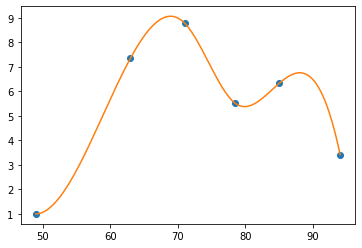

In [7]:
# complicated stuff to sort the list
sorted_number_cells = tuple(zip(*tuple(sorted(list(zip(volumes["Age"],
                                                       volumes["total_cell_number"] /
                                                       volumes.loc[0, "total_cell_number"])),
                                              key=lambda x: x[0]))))
spl = splrep(*sorted_number_cells)
x2 = np.linspace(49, 94, 200)
y2 = splev(x2, spl)
plt.plot(*sorted_number_cells, 'o', x2, y2)
plt.show()

In [8]:
def callback():
    plt.plot(*sorted_number_cells, 'o', x2, y2)

In [9]:
# Cell fate will be the first parameter to tune

### Ratio Tbr2

In [10]:
# From Betizeau et al.

ratio_eomes = pd.DataFrame({"VZ": [16.6, 13.3, 20, 43.3, 58.3],
                            "ISVZ": [88.3, 81.6, 81.6, 83.3, 75.0],
                            "OSVZ": [63.3, 43.3, 56.6, 63.3, 10.0],
                            "ratio_VZ": [43.2, 25, 12.5, 11.3, 10.2],
                            "ratio_ISVZ": [13.6, 12.5, 12.5, 4.5, 6.8],
                            "ratio_OSVZ": [42.0, 61.4, 75.0, 83.0, 81.8],
                           },
                           index=[58, 63, 70, 79, 94]
                          )

ratio_eomes

,VZ,ISVZ,OSVZ,ratio_VZ,ratio_ISVZ,ratio_OSVZ
58,16.6,88.3,63.3,43.2,13.6,42.0
63,13.3,81.6,43.3,25.0,12.5,61.4
70,20.0,81.6,56.6,12.5,12.5,75.0
79,43.3,83.3,63.3,11.3,4.5,83.0
94,58.3,75.0,10.0,10.2,6.8,81.8


In [11]:
ratio_eomes["val"] = (ratio_eomes.VZ * ratio_eomes.ratio_VZ
                   + ratio_eomes.ISVZ * ratio_eomes.ratio_ISVZ
                   + ratio_eomes.OSVZ * ratio_eomes.ratio_OSVZ) \
                  / (ratio_eomes.ratio_VZ + ratio_eomes.ratio_ISVZ + ratio_eomes.ratio_OSVZ)

ratio_eomes.val

58    46.321862
63    40.557331
70    55.150000
79    61.923482
94    19.460121
Name: val, dtype: float64

## Model

In [12]:
# Definition of the var of the model
# We start with 100 cells for homogeneity
START_POPULATION_SQRT = 10
START_TIME = 49
END_TIME = 94
# We arbitrarily set variance of Tc at 12.5^2
# 95 % seems to be into 50, so sigma = 50 / 4 = 12.5
SIG_TC = 12.5

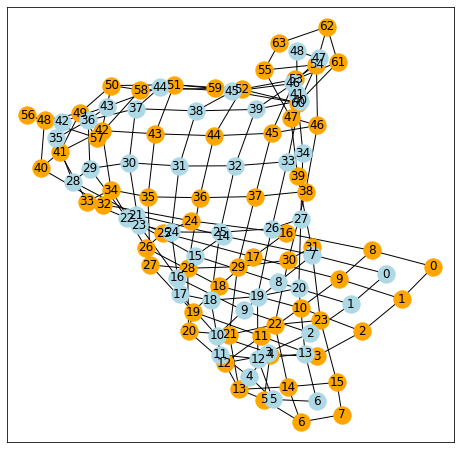

In [13]:
gpn = GrowingPlanarNetwork()
gpn.init_square(8)
gpn.show_all(figsize=(8, 8))

In [14]:
"""
k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
k_p = 0.9 * k_n
"""
pass
# This is the formula to adapt k (1/Tc) according to progenitor

In [15]:
from enum import Enum
    
class CellTypeGP(Enum):
    RG = 0
    IP = 1
    PostMitotic = 2
    Dead = 3
    GP = 4

In [16]:
# random.seed(0+0)
# np.random.seed(0+0)
# ccls = TriStateModelFactory(diff_values_RG_GP=[1., 1., 1., 0.85, 0.6])
# exp = Experiment(time_step=0.5, verbose=False, start_population=3, cell_cls=ccls.generate,
#                  check=False, cls_=Brain, safe_mode=False)
# exp.run()

In [17]:
# with Profiler():
#     random.seed(0+0)
#     np.random.seed(0+0)
#     ccls = BiStateModelFactory(tc_coeff_RG=[1., 1., 1., 1., 1.])
#     exp = Experiment(time_step=0.5, verbose=False, start_population=3, cell_cls=ccls.generate,
#                      check=False, cls_=Brain)
#     exp.run()

In [18]:
random.seed(0+0)
np.random.seed(0+0)
ccls = TriStateModelFactory(tc_coeff_RG=[1., 1., 1., 1., 1.])
bb = Brain(time_step=0.5, verbose=False, start_population=4, cell_cls=ccls.generate, check=False)
bb.run()

Removing crossing border edge 47 65 (24, 13, 0)
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 47 77 (59, 66, 0)
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 67 159 (205, 154, 0)
Removing crossing border edge 136 212 (24, 210, 0)
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 216 127 (24, 255, 0)
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 127 216 (237, 24, 0)
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 67 252 (8, 205, 0)
Removing crossing border edge 200 301 (227, 153, 0)
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 207 288 (346, 464, 0)
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 136 306 (524, 372, 0)
Quasi lonely no

Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 4356 2824 (9710, 8827, 0)
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 5490 3484 (983, 667, 0)
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 2969 5860 (5996, 11008, 0)
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Removing crossing border edge 6043 4675 (5589, 11223, 0)
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely node {node} with #ngbs = 2
Quasi lonely nod

In [19]:
bb.stats

,progenitor_pop_size,whole_pop_size,time,size_type_RG,size_type_IP,size_type_PostMitotic,size_type_GP
49.0,4.0,4.0,49.0,16.0,NaN,NaN,NaN
49.0,16.0,16.0,49.0,16.0,NaN,NaN,NaN
49.5,21.0,21.0,49.5,20.0,1.0,NaN,NaN
50.0,23.0,23.0,50.0,22.0,1.0,NaN,NaN
50.5,29.0,29.0,50.5,26.0,3.0,NaN,NaN
...,...,...,...,...,...,...,...
91.5,913.0,6190.0,91.5,106.0,140.0,52.0,615.0
92.0,913.0,6242.0,92.0,108.0,125.0,56.0,624.0
92.5,913.0,6298.0,92.5,102.0,119.0,50.0,642.0
93.0,916.0,6351.0,93.0,97.0,117.0,42.0,660.0


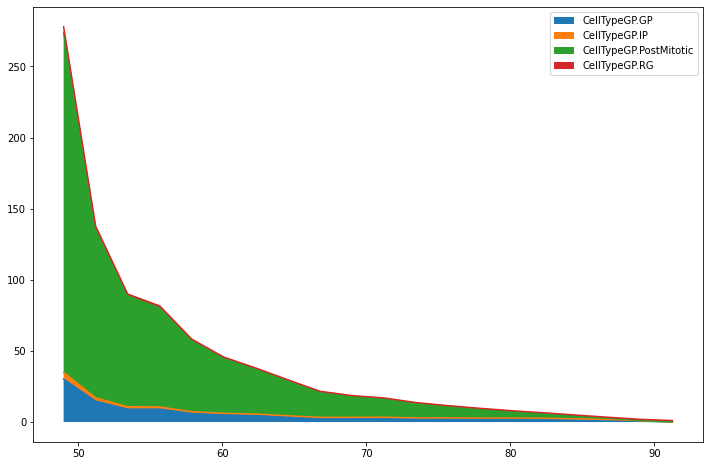

In [20]:
prog = progeny_along_time(bb, only_leaves=True)
plot_progeny(prog)

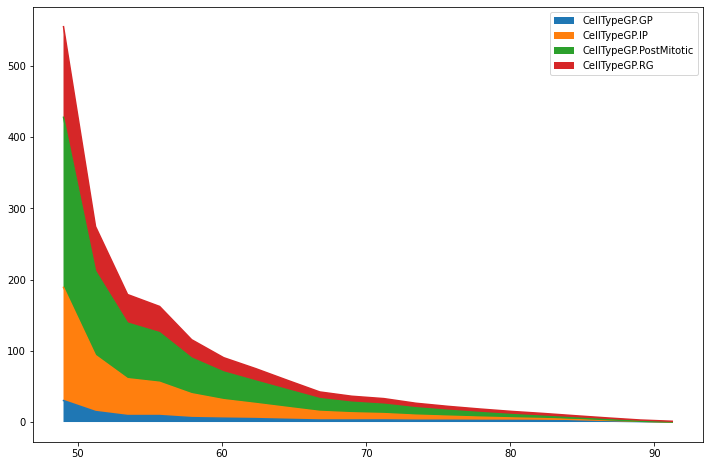

In [21]:
prog = progeny_along_time(bb, only_leaves=False)
plot_progeny(prog)

In [22]:
A = bb.root_population[0]
A

In [23]:
tree = tree_from_cell(A)

In [24]:
for node in tree.get_leaves():
    print(node.name)
    break

390


In [25]:
bb.population[1981].appear_time

66.87170703579581

In [26]:
a = tree.get_children()[0]
b = a.get_children()[0]
c = b.get_children()[0]
d = c.get_children()[0]
a, b, c, d

(Tree node '0' (-0x7ffff80eab9c118c),
 Tree node '42' (0x7f15463ee78),
 Tree node '102' (-0x7ffff80eab9c1193),
 Tree node '188' (-0x7ffff80eab9c095b))

In [27]:
def df_cells(pop):
    times = list(map(lambda x: x.appear_time, pop.values()))
    div_times = list(map(lambda x: x.division_time, pop.values()))
    types = list(map(lambda x: x.type().name, pop.values()))
    index = list(map(lambda x: x.index, pop.values()))
    parent = list(map(lambda x: x.parent, pop.values()))
    child1 = list(map(lambda x: (x.children + [None]*2)[0], pop.values()))
    child2 = list(map(lambda x: (x.children + [None]*2)[1], pop.values()))
    Tc = list(map(lambda x: np.float64(x.Tc) * 24, pop.values()))
    df = pd.DataFrame({"cell": index, "appear_time": times, "division_time": div_times,
                       "type": types, "parent": parent,
                       "D1": child1, "D2": child2, "Tc": Tc}
                     )
    return df

df = df_cells(bb.population)
df.head(20)

,cell,appear_time,division_time,type,parent,D1,D2,Tc
0,0,49.000000,50.640301,RG,NaN,42.0,43.0,65.311251
1,1,49.000000,50.095727,RG,NaN,30.0,31.0,48.262561
2,2,49.000000,50.214397,RG,NaN,32.0,33.0,66.605071
3,3,49.000000,50.153532,RG,NaN,34.0,35.0,31.044623
4,4,49.000000,50.384541,RG,NaN,36.0,37.0,41.970361
5,5,49.000000,50.066452,RG,NaN,38.0,39.0,48.393078
6,6,49.000000,49.156201,RG,NaN,16.0,17.0,52.773568
7,7,49.000000,49.162574,RG,NaN,18.0,19.0,44.781534
8,8,49.000000,50.990220,RG,NaN,46.0,47.0,48.808887
9,9,49.000000,50.579388,RG,NaN,48.0,49.0,47.431525


In [55]:
df[df["Tc"] > 1000].head(20)

,cell,appear_time,division_time,type,parent,D1,D2,Tc
3518,3518,72.328775,392.057499,GP,2589.0,NaN,NaN,7673.489390
3712,3712,72.901298,367.054244,GP,3077.0,NaN,NaN,7059.670703
3733,3733,72.502847,397.770141,GP,2554.0,NaN,NaN,7806.415058
3755,3755,72.993721,376.906811,GP,2742.0,NaN,NaN,7293.914169
3756,3756,72.621625,359.880034,GP,2762.0,NaN,NaN,6894.201831
3990,3990,73.129691,318.836154,GP,3012.0,NaN,NaN,5896.955109
4001,4001,73.173228,233.527041,GP,3050.0,NaN,NaN,3848.491515
4086,4086,73.818689,327.373390,GP,3189.0,NaN,NaN,6085.312832
4161,4161,73.988906,255.568171,GP,2968.0,NaN,NaN,4357.902378
4325,4325,74.228184,388.604014,GP,3213.0,NaN,NaN,7545.019939


<AxesSubplot:>

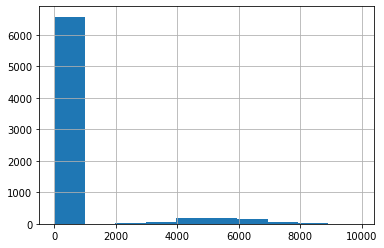

In [48]:
df["Tc"].hist()

In [28]:
tmp_df = pd.merge(df, df, how='inner', left_on="D1", right_on="cell", suffixes=('_M', '_D1'))
full_df = pd.merge(tmp_df, df.rename(columns=lambda x: x + "_D2"), how='inner', left_on="D2_M",
                   right_on="cell_D2", suffixes=('_M', '_D2'))
full_df["group"] = 2 + 1 * (full_df["appear_time_M"] > 75)
full_df

,cell_M,appear_time_M,division_time_M,type_M,parent_M,D1_M,D2_M,Tc_M,cell_D1,appear_time_D1,...,Tc_D1,cell_D2,appear_time_D2,division_time_D2,type_D2,parent_D2,D1_D2,D2_D2,Tc_D2,group
0,0,49.000000,50.640301,RG,NaN,42.0,43.0,65.311251,42,50.640301,...,33.360013,43,50.640301,53.076543,RG,0.0,124.0,125.0,58.469805,2
1,1,49.000000,50.095727,RG,NaN,30.0,31.0,48.262561,30,50.095727,...,58.889682,31,50.095727,51.727780,RG,1.0,72.0,73.0,39.169252,2
2,2,49.000000,50.214397,RG,NaN,32.0,33.0,66.605071,32,50.214397,...,50.394495,33,50.214397,52.078040,RG,2.0,88.0,89.0,44.727438,2
3,3,49.000000,50.153532,RG,NaN,34.0,35.0,31.044623,34,50.153532,...,40.428478,35,50.153532,51.674279,RG,3.0,74.0,75.0,36.497939,2
4,4,49.000000,50.384541,RG,NaN,36.0,37.0,41.970361,36,50.384541,...,36.904909,37,50.384541,52.204661,RG,4.0,90.0,91.0,43.682879,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6367,12361,91.116424,93.157056,RG,11842.0,12714.0,12715.0,48.975167,12714,93.157056,...,89.287546,12715,93.157056,95.142571,RG,12361.0,NaN,NaN,47.652362,3
6368,12372,91.543274,93.405841,IP,11951.0,12758.0,12759.0,44.701617,12758,93.405841,...,NaN,12759,93.405841,inf,PostMitotic,12372.0,NaN,NaN,NaN,3
6369,12387,91.615284,93.450324,IP,11225.0,12696.0,12697.0,44.040958,12696,93.450324,...,NaN,12697,93.450324,inf,PostMitotic,12387.0,NaN,NaN,NaN,3
6370,12389,91.554950,92.831196,IP,11715.0,12598.0,12599.0,30.629896,12598,92.831196,...,NaN,12599,92.831196,inf,PostMitotic,12389.0,NaN,NaN,NaN,3


<AxesSubplot:>

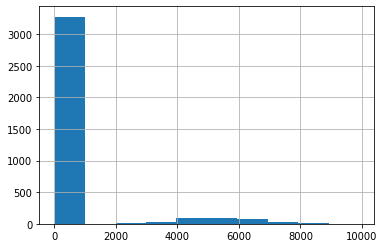

In [47]:
full_df["Tc_D2"].hist()

In [56]:
full_df[["Tc_M", "Tc_D1", "Tc_D2"]].head(5)

,Tc_M,Tc_D1,Tc_D2
0,65.311251,33.360013,58.469805
1,48.262561,58.889682,39.169252
2,66.605071,50.394495,44.727438
3,31.044623,40.428478,36.497939
4,41.970361,36.904909,43.682879


In [ ]:
df_no_gp = full_df[full_df_df[""]]

In [30]:
key1 = "Tc_M"
key2 = "Tc_D1"
filt = full_df["group"] == 3
cur_df = full_df.loc[full_df[key1].notnull() & full_df[key2].notnull() & filt, :]
stats.pearsonr(cur_df[key1], cur_df[key2])

(0.004759588485752207, 0.8393342731571107)

In [31]:
key1 = "Tc_D1"
key2 = "Tc_D2"
filt = full_df["group"] == 3
cur_df = full_df.loc[full_df[key1].notnull() & full_df[key2].notnull() & filt, :]
(cur_df[key1] / cur_df[key2]).describe()

count    1458.000000
mean       17.331862
std        41.812995
min         0.003692
25%         0.677490
50%         0.984633
75%         1.462036
max       439.883740
dtype: float64

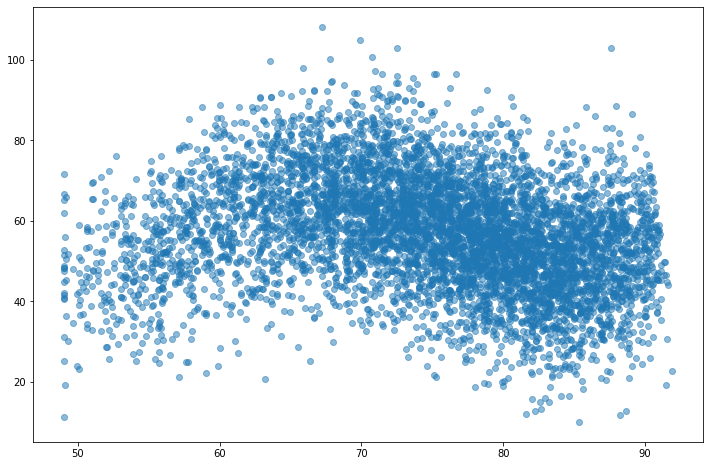

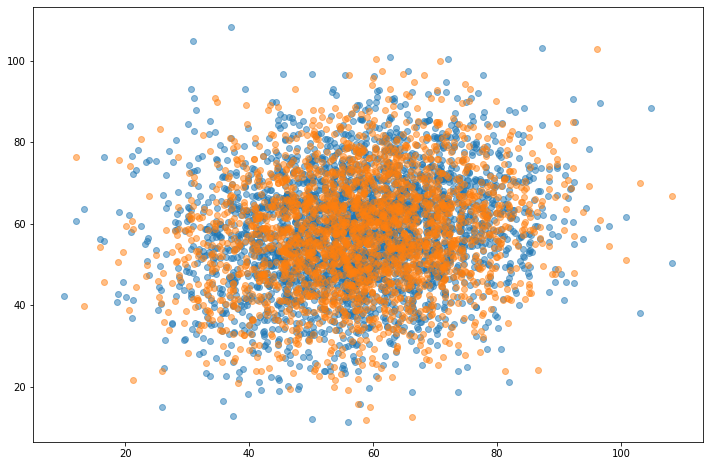

In [57]:
plt.figure(figsize=(12, 8))
plt.scatter(full_df["appear_time_M"], full_df["Tc_M"], alpha=0.5, linewidths=1)
plt.figure(figsize=(12, 8))
no_gp = (full_df["type_D1"] != "GP") & (full_df["type_D2"] != "GP")
plt.scatter(full_df["Tc_D1"][no_gp], full_df["Tc_M"][no_gp], alpha=0.5, linewidths=1)
plt.scatter(full_df["Tc_D1"][no_gp], full_df["Tc_D2"][no_gp], alpha=0.5, linewidths=1)

## Fate_cor

In [60]:
prog_df = full_df.copy()
no_gp = (full_df["type_D1"] != "GP") & (full_df["type_D2"] != "GP")
filt = prog_df["group"].isin([2, 3]) & no_gp
prog_df = prog_df[filt]
prog_df["prog_D1"] = prog_df["type_D1"].apply(lambda x: "Cycling" if x in ["IP", "RG"] else "PM")
prog_df["prog_D2"] = prog_df["type_D2"].apply(lambda x: "Cycling" if x in ["IP", "RG"] else "PM")
res_fate_cor = prog_df.groupby(["prog_D1", "prog_D2"]).size()
res_fate_cor

prog_D1  prog_D2
Cycling  Cycling    2396
         PM          638
PM       Cycling     619
         PM         2128
dtype: int64

In [61]:
CC, CN, NN = res_fate_cor[0], res_fate_cor[1] + res_fate_cor[2], res_fate_cor[3]
T = CC + CN + NN
pCC, pCN, pNN = CC / T, CN / T, NN / T
print(f"Values CC:{CC}, CN:{CN}, NN:{NN}")
print(f"Obs Prop CC:{pCC}, CN:{pCN}, NN:{pNN}")
all_C, all_N = 2 * CC + CN, 2 * NN + CN
pC, pN = all_C / (all_C + all_N), all_N / (all_C + all_N)
eCC, eCN, eNN = pC**2, 2*pC*pN, pN**2
sum_to_one = eCC + eCN + eNN
print(f"Control : {sum_to_one}")
print(f"Exp Prop CC:{eCC}, CN:{eCN}, NN:{eNN}")
F_metric = 1 - pCN / eCN
print("F_metric :", F_metric)

Values CC:2396, CN:1257, NN:2128
Obs Prop CC:0.4144611658882546, CN:0.21743642968344576, NN:0.3681024044282996
Control : 1.0
Exp Prop CC:0.27371666442100273, CN:0.49892543261794947, NN:0.22735790296104777
F_metric : 0.5641905273449008


## Relationship of Tc between mother cell and daughter cell

In [67]:
no_gp = (full_df["type_D1"] != "GP") & (full_df["type_D2"] != "GP")
filt = full_df["group"].isin([2, 3]) & no_gp
key1 = "Tc_M"
key2 = "Tc_D1"
cur_df = full_df.loc[full_df[key1].notnull() & full_df[key2].notnull() & filt, :]
var1 = cur_df[key1] / cur_df[key2]
var2 = cur_df[key1] - cur_df[key2]
np.mean(var1), np.std(var1), np.mean(var2), np.std(var2)

(1.0659857374415556,
 0.4121936285948562,
 0.19052475401855512,
 17.95541918446549)

## Cor TC daughter cells

In [68]:
# group 2
no_gp = (full_df["type_D1"] != "GP") & (full_df["type_D2"] != "GP")
filt = full_df["group"].isin([2]) & no_gp
key1 = "Tc_D2"
key2 = "Tc_D1"
cur_df = full_df.loc[full_df[key1].notnull() & full_df[key2].notnull() & filt, :]
stats.pearsonr(cur_df[key1], cur_df[key2])

(0.09903184582688049, 0.00013778012968111283)

In [69]:
# group 3
no_gp = (full_df["type_D1"] != "GP") & (full_df["type_D2"] != "GP")
filt = full_df["group"].isin([3]) & no_gp
key1 = "Tc_D2"
key2 = "Tc_D1"
cur_df = full_df.loc[full_df[key1].notnull() & full_df[key2].notnull() & filt, :]
stats.pearsonr(cur_df[key1], cur_df[key2])

(0.0551389810097378, 0.09481358352273302)

In [70]:
# group 2+3
no_gp = (full_df["type_D1"] != "GP") & (full_df["type_D2"] != "GP")
filt = full_df["group"].isin([2, 3]) & no_gp
key1 = "Tc_D2"
key2 = "Tc_D1"
cur_df = full_df.loc[full_df[key1].notnull() & full_df[key2].notnull() & filt, :]
stats.pearsonr(cur_df[key1], cur_df[key2])

(0.15771939667092488, 8.17640008877364e-15)

## Cor TC / output

In [ ]:
# we must calc nb_child_pm

In [76]:
# group 2
prog_df = full_df.copy()
no_gp = (full_df["type_D1"] != "GP") & (full_df["type_D2"] != "GP")
filt = prog_df["group"].isin([2]) & no_gp
prog_df = prog_df[filt]
prog_df["prog_D1"] = prog_df["type_D1"].apply(lambda x: "Cycling" if x in ["IP", "RG"] else "PM")
prog_df["prog_D2"] = prog_df["type_D2"].apply(lambda x: "Cycling" if x in ["IP", "RG"] else "PM")
prog_df["nb_child_pm"] = (prog_df["prog_D1"] == "PM").astype(int) + (prog_df["prog_D2"] == "PM").astype(int)
stats.pearsonr(prog_df["nb_child_pm"], prog_df["Tc_M"])

(0.005674600225405925, 0.760218689227387)

In [77]:
# group 3
prog_df = full_df.copy()
no_gp = (full_df["type_D1"] != "GP") & (full_df["type_D2"] != "GP")
filt = prog_df["group"].isin([3]) & no_gp
prog_df = prog_df[filt]
prog_df["prog_D1"] = prog_df["type_D1"].apply(lambda x: "Cycling" if x in ["IP", "RG"] else "PM")
prog_df["prog_D2"] = prog_df["type_D2"].apply(lambda x: "Cycling" if x in ["IP", "RG"] else "PM")
prog_df["nb_child_pm"] = (prog_df["prog_D1"] == "PM").astype(int) + (prog_df["prog_D2"] == "PM").astype(int)
stats.pearsonr(prog_df["nb_child_pm"], prog_df["Tc_M"])

(-0.00022714948669825912, 0.9902680237824707)

In [78]:
# group 2+3
prog_df = full_df.copy()
no_gp = (full_df["type_D1"] != "GP") & (full_df["type_D2"] != "GP")
filt = prog_df["group"].isin([2, 3]) & no_gp
prog_df = prog_df[filt]
prog_df["prog_D1"] = prog_df["type_D1"].apply(lambda x: "Cycling" if x in ["IP", "RG"] else "PM")
prog_df["prog_D2"] = prog_df["type_D2"].apply(lambda x: "Cycling" if x in ["IP", "RG"] else "PM")
prog_df["nb_child_pm"] = (prog_df["prog_D1"] == "PM").astype(int) + (prog_df["prog_D2"] == "PM").astype(int)
stats.pearsonr(prog_df["nb_child_pm"], prog_df["Tc_M"])

(-0.05438501745920217, 3.515426857401025e-05)

## Old stuff

In [34]:
bb.population[134].__dict__

{'brain': <model.Brain at 0x7f1548279390>,
 'submodel': <model.Submodels at 0x7f1548279400>,
 'appear_time': 53.471632118172565,
 'division_time': 55.770952548565816,
 'index': 134,
 'gpn_id': 75,
 '_type': <CellTypeGP.RG: 0>,
 'Tc': 2.2993204303932484,
 'eff_Tc': 2.2993204303932484,
 'parent': 77,
 'children': [334, 335],
 'divided_tag': False}

In [35]:
raise

RuntimeError: No active exception to reraise

## Experimenting

In [ ]:
def condition_number(obj):
    dist = obj.get_final_dist("whole_pop_size")
    mu, sigma, N = np.mean(dist), np.std(dist), len(dist)
    if N < 3:
        return False
    CI = stats.norm.interval(0.90, loc=mu, scale=sigma/np.sqrt(N))
    _range = CI[1] - CI[0]
    
    cond = _range < 0.01 * mu  # relative
    if cond:
        print(_range, 0.01 * mu, np.min(dist), np.max(dist), np.percentile(dist, 10), np.percentile(dist, 90))
        
    return cond

# robustness = 1 / unstability
def run_robustness_analysis(coeff=1.1, number=30, seed=0, start_population=5, max_number=200):
    results = pd.DataFrame(dict(param=[],
                               coeff=[],
                               variation_neuron=[],
                               neurons_std=[],
                               baseline_neuron=[],
                               baseline_neuron_std=[],
                               unstability_neuron=[],
                               robustness_neuron=[],
                               variation_ratio=[],
                               ratio_std=[],
                               baseline_ratio=[],
                               baseline_ratio_std=[],
                               unstability_ratio=[],
                               robustness_ratio=[]))
    
    # get baselines
    print("Computing baselines")
    random.seed(seed)
    np.random.seed(seed)
    # ccls = BiStateModelFactory()
    t_ = ("bistate1", (), {})
    exp = Experiment(time_step=0.5, verbose=False, start_population=start_population,
                     cell_cls=t_, max_number=max_number,
                     check=False, cls_=Brain)
    exp.run_parallel(condition_number)
    baseline_neuron = exp.get_final("whole_pop_size")
    baseline_neuron_std = exp.get_final_std("whole_pop_size", mean=True)
    baseline_ratio = exp.get_final_ratio()
    baseline_ratio_std = exp.get_final_ratio_std()
    
    plt.ioff()
    print("Starting Robustness experiment")
    for param in ["tc_coeff_RG", "tc_coeff_IP", "diff_coeff_RG", "diff_coeff_IP"]:
        for t in range(4):
            kw = {param: [1. if i != t else coeff for i in range(5)]}
            print(f"{param}_{t} with {kw}")
            ccls = BiStateModelFactory(**kw)
            t_ = ("bistate1", (), kw)
            random.seed(seed)
            np.random.seed(seed)
            exp = Experiment(time_step=0.5, verbose=False, start_population=start_population,
                             cell_cls=t_, number=number, max_number=max_number,
                             check=False, cls_=Brain)
            exp.run_parallel(condition_number)
            
            neurons = exp.get_final("whole_pop_size")
            print(exp.get_final_dist("whole_pop_size"))
            neurons_std = exp.get_final_std("whole_pop_size", mean=True)
            print(neurons_std)
            ratio = exp.get_final_ratio()
            ratio_std = exp.get_final_ratio_std()
            
            unstability_neuron = (neurons - baseline_neuron) / baseline_neuron
            unstability_ratio = (ratio - baseline_ratio) / baseline_ratio
            
            dd = dict(
                param=param + "_" + str(t),
                coeff=coeff,
                variation_neuron=neurons - baseline_neuron,
                baseline_neuron=baseline_neuron,
                baseline_neuron_std=baseline_neuron_std,
                neurons_std=neurons_std,
                unstability_neuron=unstability_neuron,
                robustness_neuron=abs(1 / (1e-6 + unstability_neuron)),
                variation_ratio=ratio - baseline_ratio,
                ratio_std=ratio_std,
                baseline_ratio=baseline_ratio,
                baseline_ratio_std=baseline_ratio_std,
                unstability_ratio=unstability_ratio,
                robustness_ratio=abs(1 / (1e-6 + unstability_ratio)),
            )
            results = results.append(dd, ignore_index=True)
            
            # saving figures
            exp.show_pop()
            plt.savefig(f"output/stack/population_{param}_{t}.png")
            plt.close()
            exp.show_progenitor_pop()
            plt.savefig(f"output/stack/progenitor_{param}_{t}.png")
            plt.close()
            exp.show_ratio_IP(ratio_eomes)
            plt.savefig(f"output/stack/ratio_IP_{param}_{t}.png")
            plt.close()

    plt.close()
    plt.ion()
    return results

In [ ]:
# random.seed(0+0)
# np.random.seed(0+0)
# ccls = BiStateModelFactory(tc_coeff_RG=[1., 1., 1., 1., 1.])
# bb = Brain(time_step=0.5, verbose=False, start_population=3, cell_cls=CellBasic, check=False)
# bb.run()
# raise

In [ ]:
results = run_robustness_analysis(number=30, seed=0, start_population=5, max_number=200)
results.to_csv("output/robustness_rect4.csv")
results.head()

In [ ]:
results

In [ ]:
raise

In [ ]:
results.append(dict(param=0,
                   coeff=0,
                   variation=0,
                   baseline=0,
                   unstability=0,
                   robustness=0), ignore_index=True)

In [ ]:
plt.figure(figsize=(20, 20))
Counter(dict(bb.gpn.G.degree()).values())

In [ ]:
bb.stats

In [ ]:
plt.figure(figsize=(10, 10))
p1 = plt.plot(bb.stats.time, bb.stats.progenitor_pop_size, label="Progenitor population")
p2 = plt.plot(bb.stats.time, bb.stats.whole_pop_size, label="Whole Population")
plt.legend()
# plt.legend((p1, p2), ("Progenitor population", "Whole Population"))

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(bb.stats.time, bb.stats.size_type_RG, label="RG number")
plt.plot(bb.stats.time, bb.stats.size_type_IP, label="IP number")
plt.legend()

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(bb.stats.time, bb.stats.size_type_IP / (bb.stats.size_type_RG + bb.stats.size_type_IP),
         label="IP ratio")
plt.plot(ratio_eomes.index, ratio_eomes.val / 100, label="Reference IP ratio")
plt.legend()

In [ ]:
raise